### Amazon dataset category prediction - Bayesian Model

The big idea here is to use Bayesian inference to model the posterior distribution for each user's purchase category probability distribution. This will allow us to assign confidence to the predictions of a model based only on user history. Using this information, we can combine our user history model with our NLP text classification model in a more principled way.

The basic plan is:
1. Predict review category with NLP model based on text, and preserve vector of Softmax category probabilities.
2. Predict review category with Bayesian user history model, cast as a Multinomial distribution for each user.
3. Blend the two models taking into account the strength of the prediction of each.

We have reason to think this may be effective. Over 99% of the users in the test set have also appeared in the training set. A simple model in which we predict the category that a user more frequently purchased previously acheived about 82% test accuracy. Meanwhile, an LSTM text classification model also acheived about 82% accuracy. But the two models only agree 77% of the time, so there is potential to combine the models in such a way as to get up to 93.5% accuracy (if we had perfect knowledge but were constrained to choosing between the two mdoels' predictions).

An ad-hoc blend based on some fairly arbitrary heuristics produced 85% accuracy, so this is a promising start and suggests that an even better blend is possible.

In [1]:
import pandas as pd
import numpy as np
import gzip
from collections import defaultdict

In [2]:
# Import Select Columns

def readGz(f):
  for l in gzip.open(f):
    yield eval(l)

train_users = []
for l in readGz("train.json.gz"):
    train_users.append(l['reviewerID'])

    
categories = []
# for l in readGz("/content/drive/My Drive/train.json.gz"):
for l in readGz("train.json.gz"):
    categories.append(l['categoryID'])

In [3]:
# Convert to Pandas df
train_users_df = pd.DataFrame(train_users, columns = ['ReviewerID'])
train_users_df['categoryID'] = pd.DataFrame(categories, columns = ['categoryID'])
train_users_df.head()

,ReviewerID,categoryID
0,U490934656,0
1,U714157797,0
2,U507366950,0
3,U307862152,0
4,U742726598,0


The next step is to get the data into the format where each user has one row, containing their ReviewerID, the number $n$ of times they appear in the dataset, and the proportion of their reviews that are in each category 0 through 4, $p_0$ through $p_4$.

In [4]:
train_users_df['Cat0'] = np.where(train_users_df['categoryID'] == 0, 1, 0)
train_users_df['Cat1'] = np.where(train_users_df['categoryID'] == 1, 1, 0)
train_users_df['Cat2'] = np.where(train_users_df['categoryID'] == 2, 1, 0)
train_users_df['Cat3'] = np.where(train_users_df['categoryID'] == 3, 1, 0)
train_users_df['Cat4'] = np.where(train_users_df['categoryID'] == 4, 1, 0)
train_users_df.head()

,ReviewerID,categoryID,Cat0,Cat1,Cat2,Cat3,Cat4
0,U490934656,0,1,0,0,0,0
1,U714157797,0,1,0,0,0,0
2,U507366950,0,1,0,0,0,0
3,U307862152,0,1,0,0,0,0
4,U742726598,0,1,0,0,0,0


In [5]:
train_users_grouped = train_users_df.groupby('ReviewerID').sum()
train_users_grouped = train_users_grouped.drop(columns = ['categoryID'])
train_users_grouped.head()

,Cat0,Cat1,Cat2,Cat3,Cat4
ReviewerID,,,,,
U000005569,5,0,0,0,0
U000024709,10,0,0,0,0
U000041850,5,1,0,0,2
U000089279,0,1,0,1,0
U000131684,2,0,0,1,0


In [6]:
train_users_grouped['N'] = (train_users_grouped['Cat0'] + train_users_grouped['Cat1'] 
                            + train_users_grouped['Cat2']  + train_users_grouped['Cat3']  
                            + train_users_grouped['Cat4']) 
train_users_grouped.head()

,Cat0,Cat1,Cat2,Cat3,Cat4,N
ReviewerID,,,,,,
U000005569,5,0,0,0,0,5
U000024709,10,0,0,0,0,10
U000041850,5,1,0,0,2,8
U000089279,0,1,0,1,0,2
U000131684,2,0,0,1,0,3


In [7]:
len(train_users_grouped)

39239

### Step 2: Bayesian Modeling

Now that the data is shaped the way we need it, we can begin setting up the Bayesian model. We will use PyMC3 to estimate the Bayesian posteriors.

#### Model Definition

We will model user $k$'s number of purchases (or equivalently reviews) $n^{(k)}_0, ...,n^{(k)}_4 \sim Multinomial( \mu^{(k)}_0,...,\mu^{(k)}_4, N^{(k)}) $ with user $k$ making $N^{(k)}$ total purchases across 5 categories, numbered 0 through 4. The parameter $\mu^{(k)}_i$ represents the propobability that a particular item purchased (reviewed) by user $k$ will be from category $i$.

The priors for $\mu^{(k)}_i \sim Dirichlet(\alpha^{(k)}_0,...,\alpha^{(k)}_4)$.



In [8]:
import pymc3 as pm
import arviz as az

First, let's run the inference simulation on a small number of examples so we can explore the posterior distributions.

In [9]:
# Run inference on a small sample to begin experimenting with how to explore the posterior
data_sample = train_users_grouped.iloc[0:5]
data_sample.head()

,Cat0,Cat1,Cat2,Cat3,Cat4,N
ReviewerID,,,,,,
U000005569,5,0,0,0,0,5
U000024709,10,0,0,0,0,10
U000041850,5,1,0,0,2,8
U000089279,0,1,0,1,0,2
U000131684,2,0,0,1,0,3


In [221]:
# Model definition as above, using PyMC3
with pm.Model() as category_model:
    mu = pm.Dirichlet("mu", 
                      a = np.ones(5),
                      shape = (len(data_sample), 5)
                     )
    like = pm.Multinomial("like", 
                          p = mu, 
                          n = data_sample['N'], 
                          observed = np.array((data_sample['Cat0'],
                                             data_sample['Cat1'],
                                             data_sample['Cat2'],
                                             data_sample['Cat3'],
                                             data_sample['Cat4'])).T
                         )

#### Sample from posterior

In [222]:
with category_model:
    trace = pm.sample(1000)
#     prior = pm.sample_prior_predictive()
#     posterior_predictive = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]

Sampling 4 chains: 100%|███████████████████████████████████████████████████| 6000/6000 [00:06<00:00, 952.22draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000238A56B3188>,
      dtype=object)

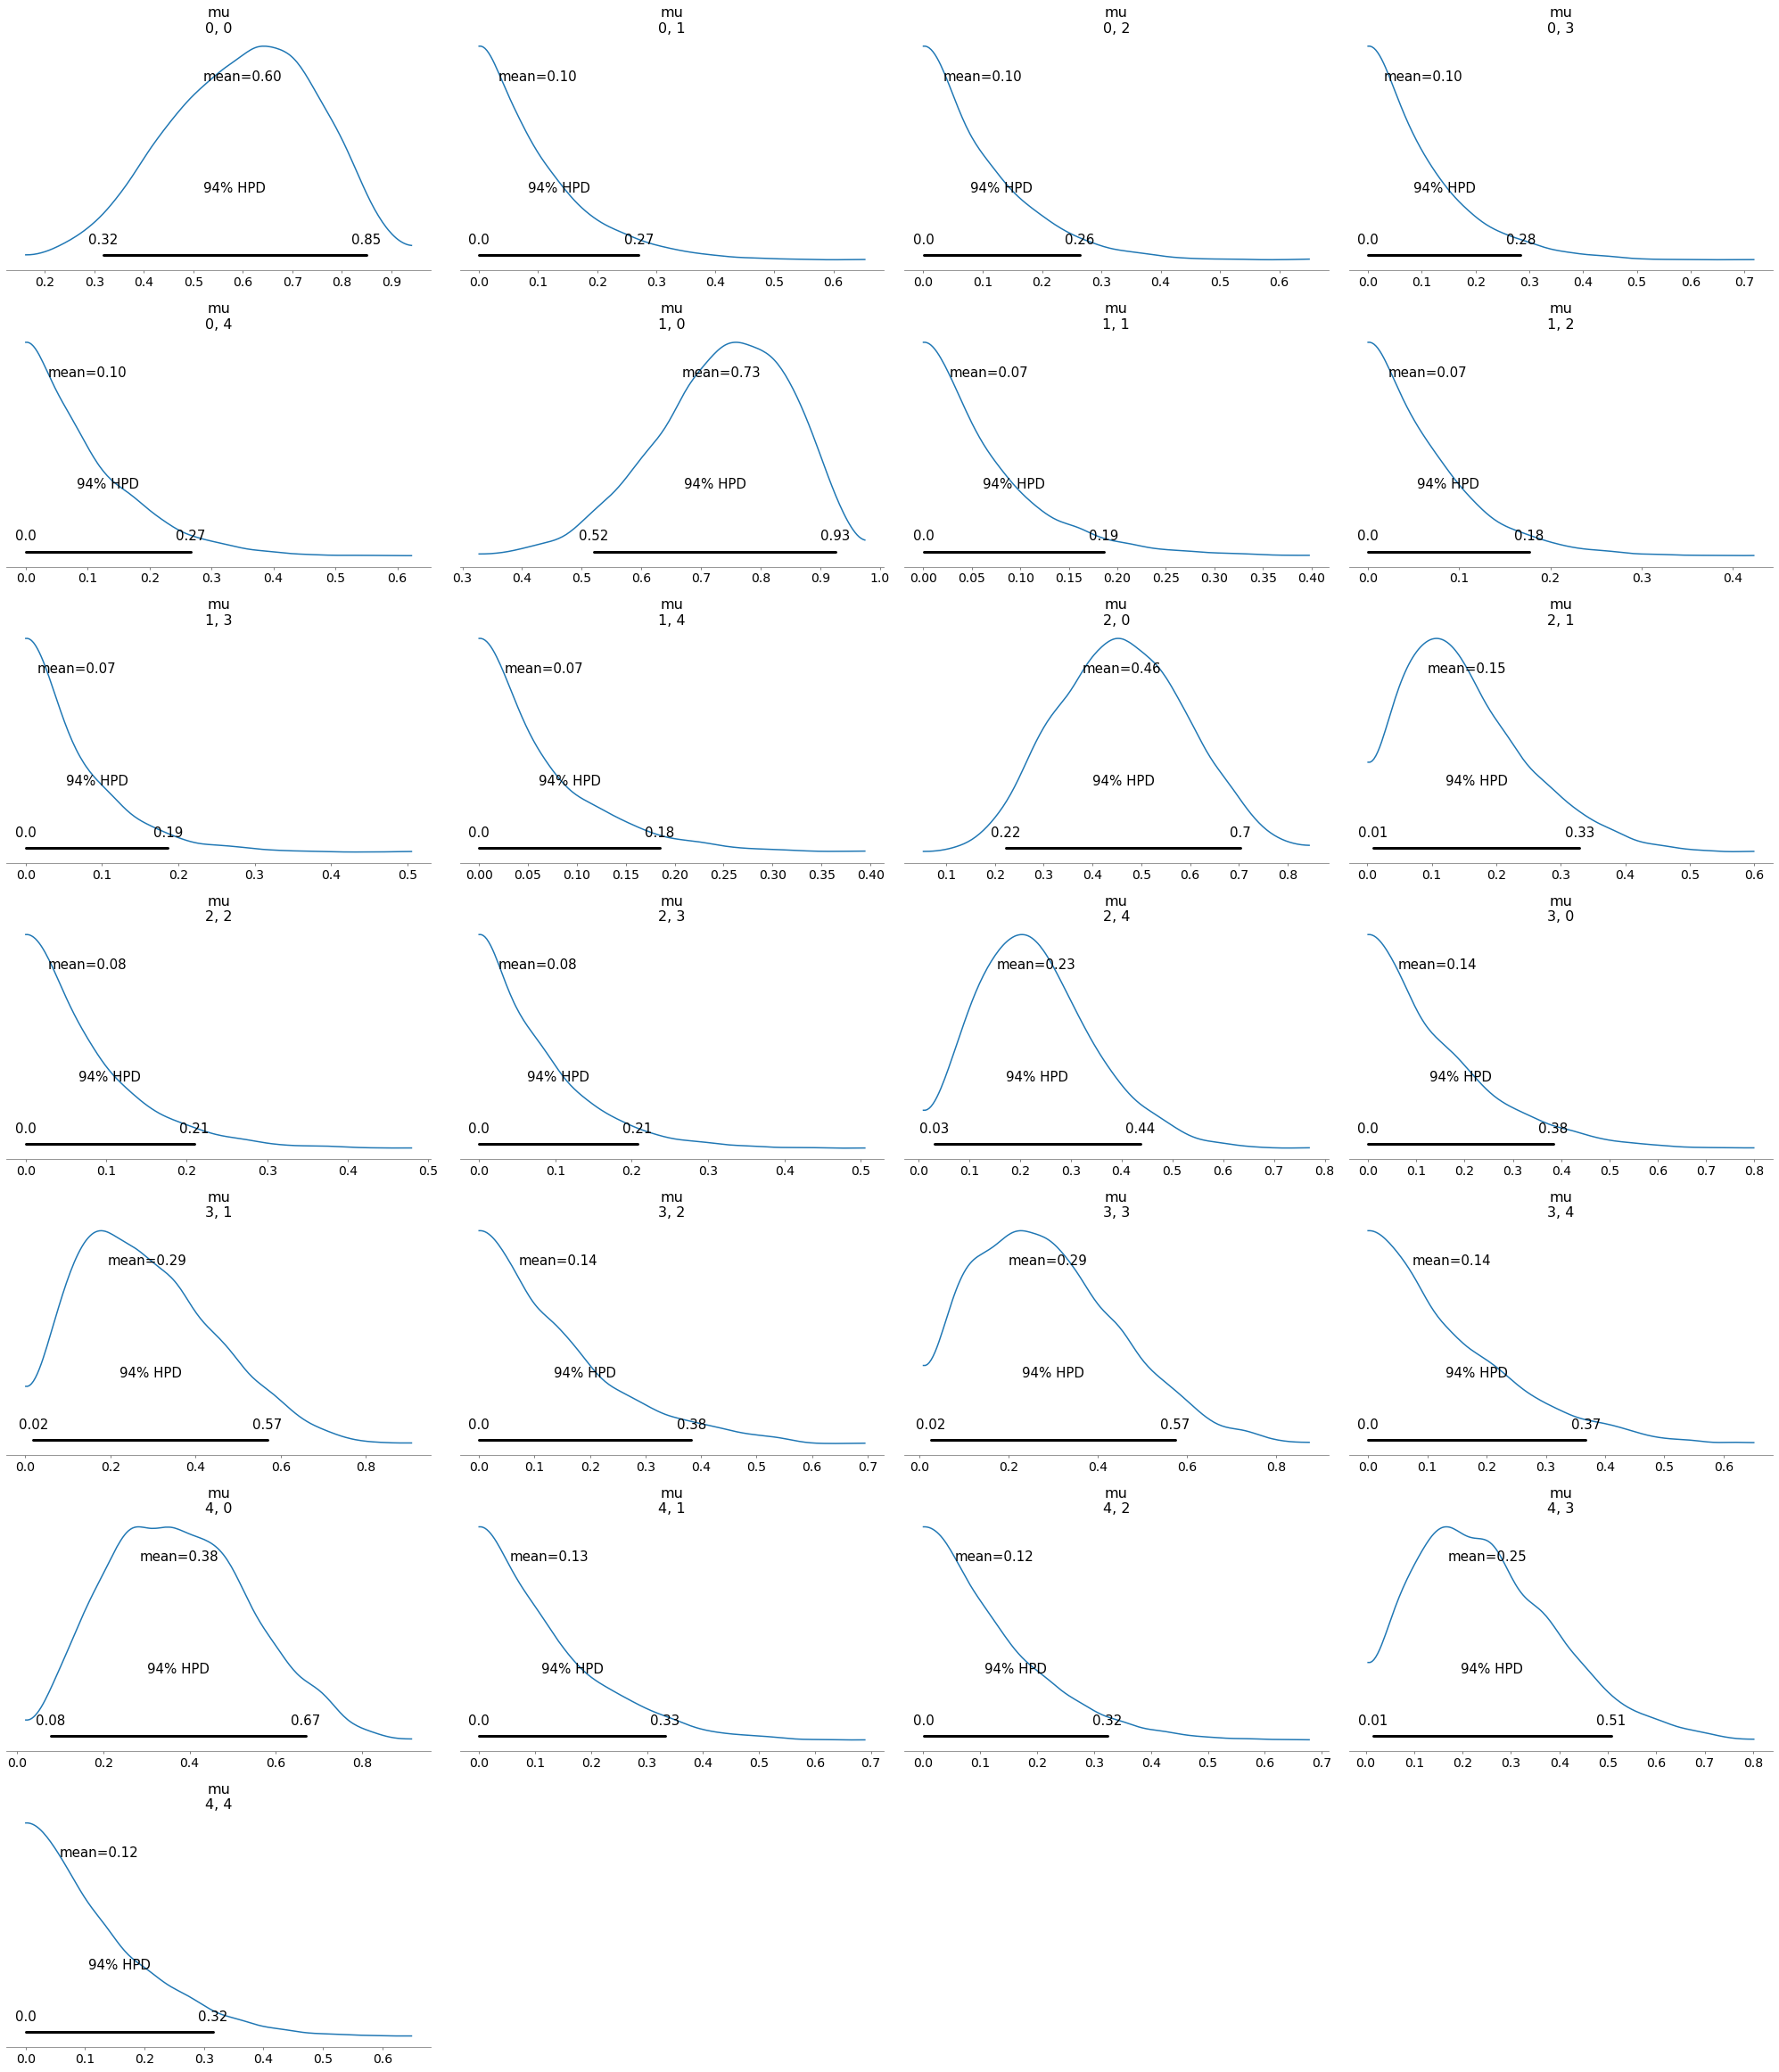

In [223]:
# Density plots
az.plot_posterior(trace, round_to = 2)

C:\Users\joncu\.conda\envs\bayesian-modelling-tutorial\lib\site-packages\arviz\plots\forestplot.py:207: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
  ticks.tick1On = False
C:\Users\joncu\.conda\envs\bayesian-modelling-tutorial\lib\site-packages\arviz\plots\forestplot.py:208: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
  ticks.tick2On = False


(<Figure size 432x1008 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002388D3DFA48>],
       dtype=object))

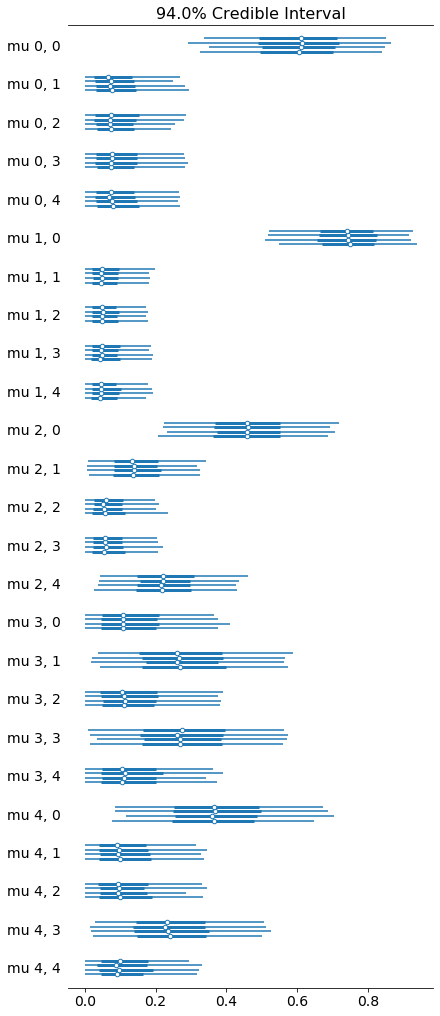

In [233]:
az.plot_forest(trace, var_names = ['mu'])

Notice how we get strong indications of how credible our estimates are. We won't need to take advantage of the entire posterior distribution, but the imposition of the prior (where $\mu_0 = ... = \mu_4 = 0.2$) allows us to take even the mean of the posterior distributions as a measure of our confidence in a prediction of a particular category.

Where the history prediction disagrees with the NLP model's prediction, we will pick the greater of the probability assigned by the NLP model or the mean of the posterior distribution in the Bayesian history model.

Now let's repeat this for the full dataset. Actually, not the _full_ dataset. Hamiltonian Monte Carlo is computationally intensive, and we know which users are in the test set, so let's limit this process to the users who actually appear in the test set.

In [10]:
# Import test reviewers
def readGz(f):
  for l in gzip.open(f):
    yield eval(l)

test_users = []
for l in readGz("test_Category.json.gz"):
    test_users.append(l['reviewerID'])
len(test_users)

14000

In [11]:
test_users_unique = np.unique(np.array(test_users))
test_users_unique.shape

(11698,)

In [12]:
train_users_keep = train_users_grouped[train_users_grouped.index.isin(list(test_users_unique))]
train_users_keep

,Cat0,Cat1,Cat2,Cat3,Cat4,N
ReviewerID,,,,,,
U000024709,10,0,0,0,0,10
U000243198,0,3,0,0,0,3
U000382648,6,1,0,0,0,7
U000442276,17,0,0,0,0,17
U000446326,4,0,0,0,0,4
...,...,...,...,...,...,...
U999507933,6,1,0,0,0,7
U999619138,3,0,0,0,0,3
U999688170,2,1,0,0,0,3


This reduced the dataset from 39,000 rows to under 12,000 rows.

In [13]:
# Model definition as above, using PyMC3
with pm.Model() as full_model:
    mu = pm.Dirichlet("mu", 
                      a = np.ones(5),
                      shape = (len(train_users_keep), 5)
                     )
    like = pm.Multinomial("like", 
                          p = mu, 
                          n = train_users_keep['N'], 
                          observed = np.array((train_users_keep['Cat0'],
                                             train_users_keep['Cat1'],
                                             train_users_keep['Cat2'],
                                             train_users_keep['Cat3'],
                                             train_users_keep['Cat4'])).T
                         )

C:\Users\joncu\.conda\envs\bayesian-modelling-tutorial\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [14]:
with full_model:
    trace_full = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|████████████████████████████████████████████████████| 6000/6000 [28:11<00:00,  3.55draws/s]
The acceptance probability does not match the target. It is 0.6441340665578243, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6870236708555574, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7044806812556154, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7112482923148732, but should be close to 0.8. Try to increase the number of tuning steps.


### Export posterior predictions

Now that we have estimated our posterior distributions, we will export both the predicted class (argmax) and the confidence in the prediction (max mu).

In [15]:
mu_hats = np.array(list(az.summary(trace_full)['mean'])).reshape(-1, 5)
predictions = np.argmax(mu_hats, axis = 1)
probs = np.max(mu_hats, axis = 1)

In [17]:
bayes_priors = pd.DataFrame(train_users_keep.index)
bayes_priors['Prediction'] = predictions
bayes_priors['Likelihood'] = probs
bayes_priors.head()

,ReviewerID,Prediction,Likelihood
0,U000024709,0,0.736
1,U000243198,1,0.499
2,U000382648,0,0.579
3,U000442276,0,0.818
4,U000446326,0,0.555


In [19]:
bayes_priors.to_csv('bayesian_predictions.csv', index = False)